# Noise2Void - 2D Example for SEM data

__Note:__ This notebook expects a trained model and will only work if you have executed the `01_training.ipynb` beforehand.

In [19]:
!pip install tensorflow==2.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
%%bash
git clone https://github.com/microscopy-processing/n2v.git
cd n2v
pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/n2v
  Attempting uninstall: n2v
    Found existing installation: n2v 0.3.2
    Can't uninstall 'n2v'. No files were found to uninstall.
  Running setup.py develop for n2v


fatal: destination path 'n2v' already exists and is not an empty directory.


In [21]:
import sys
sys.path.append("n2v")

In [22]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible

## Load the Network

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!mkdir models
!mkdir models/n2v_2D

mkdir: cannot create directory ‘models’: File exists
mkdir: cannot create directory ‘models/n2v_2D’: File exists


In [25]:
!ls drive/Shareddrives/TomogramDenoising/notebooks/N2V/2D/SEM/

01_training.ipynb  02_prediction.ipynb	config.json  export.bioimage.io.zip


In [26]:
!cp drive/Shareddrives/TomogramDenoising/notebooks/N2V/2D/SEM/export.bioimage.io.zip models/n2v_2D
!cp drive/Shareddrives/TomogramDenoising/notebooks/N2V/2D/SEM/config.json models/n2v_2D
#!mkdir data
#!cp drive/Shareddrives/TomogramDenoising/notebooks/N2V/2D/testinput.tif data/train.tif
#!cp drive/Shareddrives/TomogramDenoising/notebooks/N2V/2D/testoutput.tif data/validation.tif

In [27]:
# A previously trained model is loaded by creating a new N2V-object without providing a 'config'.  
model_name = 'n2v_2D'
basedir = 'models'
model = N2V(config=None, name=model_name, basedir=basedir)

/usr/local/lib/python3.7/dist-packages/csbdeep/models/base_model.py:162: UserWarning: Couldn't find any network weights (*.h5, *.hdf5) to load.
  warnings.warn("Couldn't find any network weights (%s) to load." % ', '.join(weights_ext))


In [28]:
# In case you do not want to load the weights that lead to lowest validation loss during 
# training but the latest computed weights, you can execute the following line:

# model.load_weights('weights_last.h5')

# Download Example Data
Data by Reza Shahidi and Gaspar Jekely, Living Systems Institute, Exeter<br>
Thanks!

In [29]:
import urllib
import os
import zipfile

# create a folder for our data.
if not os.path.isdir('./data'):
    os.mkdir('./data')

# check if data has been downloaded already
zipPath="data/SEM.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://download.fht.org/jug/n2v/SEM.zip', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

## Prediction
Here we will simply use the same data as during training and denoise it using our network.

In [36]:
# We load the data we want to process.
input_train = imread('data/train.tif')
print(input_train.shape)

# Downscale the images
import cv2
scaled_img = cv2.resize(input_train, dsize=(512,512))
#scaled_img.resize((1, 512, 512, 1))
input_train = scaled_img

# Here we process the data.
# The parameter 'n_tiles' can be used if images are to big for the GPU memory.
# If we do not provide the n_tiles' parameter the system will automatically try to find an appropriate tiling.
# This can take longer.
pred_train = model.predict(input_train, axes='YX', n_tiles=(2,1))

# We load and process the data we previously used for validation.
input_val = imread('data/validation.tif')

scaled_img = cv2.resize(input_val, dsize=(512,512))
#scaled_img.resize((1, 512, 512, 1))
input_val = scaled_img

pred_val = model.predict(input_val, axes='YX')

(2500, 1690)


100%|██████████| 2/2 [00:00<00:00,  2.12it/s]


### Show results on training data...

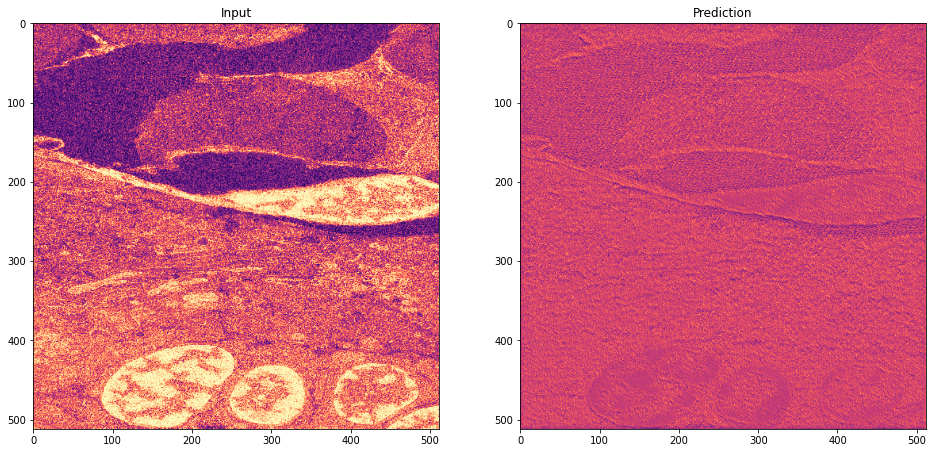

In [37]:
# Let's look at the results.
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(input_train[:1500:,:1500],cmap="magma")
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred_train[:1500,:1500],cmap="magma")
plt.title('Prediction');

### Show results on validation data...

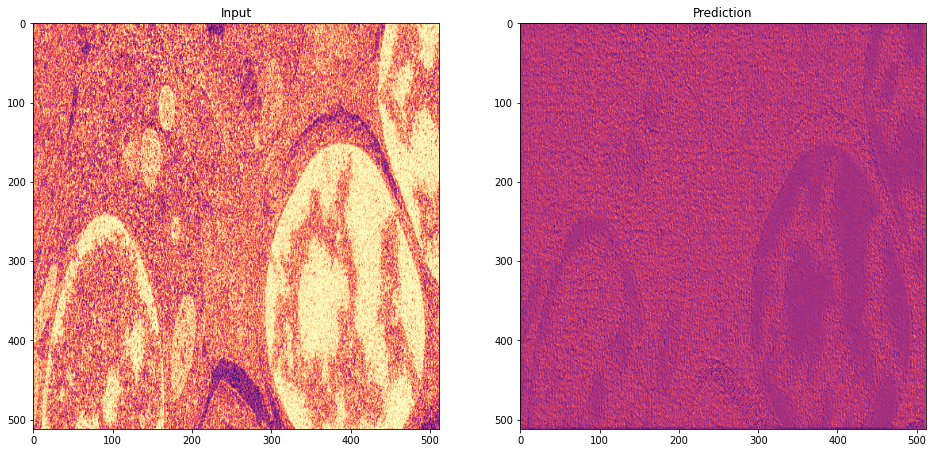

In [38]:
# Let's look at the results.
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(input_val,cmap="magma")
plt.title('Input');
plt.subplot(1,2,2)
plt.imshow(pred_val,cmap="magma")
plt.title('Prediction');

## Save Results

In [33]:
save_tiff_imagej_compatible('pred_train.tif', pred_train, axes='YX')
save_tiff_imagej_compatible('pred_validation.tif', pred_val, axes='YX')